# AQREIGHT COMPUTER VISION TECHNICAL ASSESSMENT

## APPLICANT'S NAME: AHMAD ZHAFRI HARIZ BIN ROSLAN

# Notebook overview
In this notebook, the data pipelining and model development will  be done. The summary from the EDA process has ensure several issues regarding the dataset.

*   The test dataset is significantly imbalance, however the training and validation dataset are balance with each class having 10 samples.
*   The image dimension shows a slight rectangle shape from the aspect ratio
*   From the colour channel distribution analysis, it shows that the dataset is high contrast.

From the summary above, I need to carefully select what kind of data augmentation that I need to mitigate any misclassification.





## 1. Data Pipelining
The first section of this notebook will be on data pipelining. Here the data augmentation process will also happen. Since I will be using the training dataset from pytorch, I won't be doing any data splitting as the split already took place.

Loading import libraries

In [1]:
import torchvision
import torch
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
import numpy as np

In [2]:


# Training transforms include heavy augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # Resize the image to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30), # Rotate by up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # the fix for colour distribution
    transforms.ToTensor(), # convert from 0-255 to 0-1.0
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# Use the default ImageNet values
])

# Validation transforms only involve resizing and center cropping
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets with respective transforms
train_dataset = datasets.Flowers102(root="data", split="train",
                                    download=True, transform=train_transforms)

# Note: Flowers102 uses 'test' or 'val'. 'val' is typically used for monitoring during training.
val_dataset = datasets.Flowers102(root="data", split="val",
                                  download=True, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

100%|██████████| 345M/345M [00:13<00:00, 26.2MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.23MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 26.7MB/s]


Based on the code above, for the training augmentation:</br>


*   RandomResizedCrop(224): Because of the aspect ratio value is 1.19, the function takes a random patch of the image and converts it to 224x224. Since the aspect ratio are not that significant, the crop size won't lose much context.
*   RandomHorizontalFlip() and RandomRotation(30): These functions help the model to learn geometric invariance. With horizontal flip it will be the mirrored image and rotation(30) simply teaches the model the flower will still be a flower if tilted 30 degrees.


*   ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2): This is the fix for the colour distribution problem that I found. The Colour jitter randomly shift the contrast and brightness on the images. This will teach the model without relying on specific lighting condition.
*   Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): Here I used the ImageNet default values jsut to see if how the result will be. Later I will try to change if the model's preformance might increase should I change the value.





As for the validation, I only use the Resize() and CenterCrop() functions for augmentation. This is because the validation dataset is not used for training but only helps me monitor the training's performance.

The code block below will plot the 4 samples from the dataloader after the augmentation process. Since the image is normalize to tensor, I have to reverse the process to obtain the original range.

Next i took a batch of the training data to display the result of the augmentation.

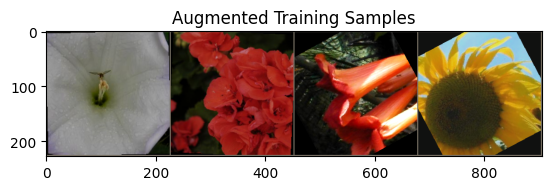

In [3]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Un-normalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title="Augmented Training Samples")

### Early Stopping mechanism
The code below is my implementation of early stopping to my training pipeline.
The purpose of the early stopping mechanism is to stop the training process when monitoring the validation metric. When the model's performance on the validation dataset is not improving, it will save the best model and proceed to stop the training.



*   patience is set to 5 epochs to wait for any improvement. Here I set to 5 to allow some room for the model to make improvement.
*   min_delta is set to 0 which is going to be the minimum change that can qualify as an improvement.


*   the counter counts how many bad epochs have passed in a row
*   best_loss will stores the lowest validation so far.

I also apply save_checpoint() function to ensure that it will select the best model to save. This is because the last epoch is not always the best epoch. At the end of the training, the last few epochs will tend to exhibit overffiting, therefore the function will compare all epochs trained and select the best performing model.





In [4]:

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='best_model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

### Training Loop
Since I'm using pytorch to train, torch.device() will detect what harware accelaration that I'm using.
<p> For this specific assessment, the training is done in google colab using the T4 free GPU.

<p> In the training loop:
I will comparing 3 models to compare which model is the best one. The 3 models are ResNet50, ConvNext-tiny, and ViT. The models are used to compare because :


*   ResNet50 are considered the 'Golden standard' for image classification and also as backbone feature extractor.
*   Where as ViT are considered more advance since it uses Transformer and attention mechanism to understand global context.


*   While ConvNext is the modernize version of CNNs that borrows ideas from ViT such as patch stems and inverted bottleneck






In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,model_name="model", num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)


    save_path = f'{model_name}_flowers.pt'
    early_stopping = EarlyStopping(patience=5, path=save_path)
    print(f"Starting training for {model_name}...")
    print(f"Best model will be saved to: {save_path}")
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    for epoch in range(num_epochs):
        # --- TRAINING PHASE ---
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        current_lr = optimizer.param_groups[0]['lr']

        # --- VALIDATION PHASE ---
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)

        # Update History
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        history['lr'].append(current_lr)

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | LR: {current_lr:.6f}')

        # Step the scheduler
        scheduler.step(val_loss)

        # Check Early Stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered. Model saved at {save_path}")
            break

    return model, history

From the code above, in the training phase:


*   The gradient is managed by optimizer.zero_grad() that will clear the old gradient so that they don't accumulate.
*   In the forward pass,the model make prediction on a batch of images.


*   the loss.backward() is for the backpropagation to calculate the loss and optimizer.step() will update the weights to reduce the loss error.
*   During training, the model's accuracy, loss, validation loss, validation accuracy, and learning rate are being monitored.





In [6]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim


def get_flower_model(model_name="resnet50", num_classes=102, pretrained=True):
    """
    Factory function to fetch and prepare models for Flowers102.
    Options: 'resnet50', 'convnext_tiny', 'vit_b_16'
    """
    if model_name == "resnet50":
        weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        model = models.resnet50(weights=weights)
        # ResNet uses .fc for the final layer
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "convnext_tiny":
        weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.convnext_tiny(weights=weights)
        # ConvNeXt uses a classifier block with a sequence of layers
        # The final linear layer is the last element in the 'classifier' head
        in_features = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(in_features, num_classes)

    elif model_name == "vit_b_16":
        weights = models.ViT_B_16_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.vit_b_16(weights=weights)
        # ViT uses .heads for the classification layers
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

    else:
        raise ValueError(f"Model {model_name} not supported. Choose from resnet50, convnext_tiny, vit_b_16")

    return model

The code above I used a factory function that will select the models based on parameter value.
<p>For all models, I used ImageNet pre-trained weights for transfer learning. A full fine tuning was employas the free tier GPU was enough to fully train all 3 models.

In [7]:


def plot_model_comparison(histories_dict):


    plt.figure(figsize=(18, 6))

    # 1. Compare Validation Loss
    plt.subplot(1, 2, 1)
    for model_name, history in histories_dict.items():
        epochs = range(1, len(history['val_loss']) + 1)
        plt.plot(epochs, history['val_loss'], label=f'{model_name} Val Loss')

    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # 2. Compare Validation Accuracy
    plt.subplot(1, 2, 2)
    for model_name, history in histories_dict.items():
        epochs = range(1, len(history['val_acc']) + 1)
        plt.plot(epochs, history['val_acc'], label=f'{model_name} Val Acc')

    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

The code will loop every model. For each model, the history log is save in 1 master dictionary. This is to make it easier for me to compare their results in the following section.
<p> All hyperparameter are the same for all 3 models to make a fair comparison.


--- Training resnet50 ---
Starting training for resnet50...
Best model will be saved to: resnet50_flowers.pt
Epoch 0/24
Train Loss: 4.5744 Acc: 0.0471 | Val Loss: 4.3895 Acc: 0.1569 | LR: 0.000100
Epoch 1/24
Train Loss: 4.1497 Acc: 0.2833 | Val Loss: 3.4551 Acc: 0.4716 | LR: 0.000100
Epoch 2/24
Train Loss: 3.1592 Acc: 0.5294 | Val Loss: 1.8893 Acc: 0.6412 | LR: 0.000100
Epoch 3/24
Train Loss: 2.0913 Acc: 0.6804 | Val Loss: 1.1571 Acc: 0.7863 | LR: 0.000100
Epoch 4/24
Train Loss: 1.3327 Acc: 0.8039 | Val Loss: 0.8494 Acc: 0.8333 | LR: 0.000100
Epoch 5/24
Train Loss: 0.9145 Acc: 0.8529 | Val Loss: 0.6623 Acc: 0.8578 | LR: 0.000100
Epoch 6/24
Train Loss: 0.7647 Acc: 0.8618 | Val Loss: 0.5562 Acc: 0.8814 | LR: 0.000100
Epoch 7/24
Train Loss: 0.4979 Acc: 0.9206 | Val Loss: 0.5086 Acc: 0.8824 | LR: 0.000100
Epoch 8/24
Train Loss: 0.4664 Acc: 0.9216 | Val Loss: 0.4574 Acc: 0.8941 | LR: 0.000100
Epoch 9/24
Train Loss: 0.3620 Acc: 0.9314 | Val Loss: 0.4204 Acc: 0.9069 | LR: 0.000100
Epoch 10/2

100%|██████████| 109M/109M [00:00<00:00, 183MB/s]


Starting training for convnext_tiny...
Best model will be saved to: convnext_tiny_flowers.pt
Epoch 0/24
Train Loss: 4.4939 Acc: 0.0637 | Val Loss: 4.0053 Acc: 0.2598 | LR: 0.000100
Epoch 1/24
Train Loss: 3.6262 Acc: 0.3765 | Val Loss: 2.9593 Acc: 0.6137 | LR: 0.000100
Epoch 2/24
Train Loss: 2.6254 Acc: 0.6902 | Val Loss: 2.0442 Acc: 0.7618 | LR: 0.000100
Epoch 3/24
Train Loss: 1.8098 Acc: 0.7980 | Val Loss: 1.4296 Acc: 0.8422 | LR: 0.000100
Epoch 4/24
Train Loss: 1.3178 Acc: 0.8539 | Val Loss: 1.0383 Acc: 0.8745 | LR: 0.000100
Epoch 5/24
Train Loss: 0.9281 Acc: 0.9127 | Val Loss: 0.8011 Acc: 0.9098 | LR: 0.000100
Epoch 6/24
Train Loss: 0.6771 Acc: 0.9490 | Val Loss: 0.6333 Acc: 0.9265 | LR: 0.000100
Epoch 7/24
Train Loss: 0.5264 Acc: 0.9578 | Val Loss: 0.5304 Acc: 0.9284 | LR: 0.000100
Epoch 8/24
Train Loss: 0.4251 Acc: 0.9657 | Val Loss: 0.4726 Acc: 0.9324 | LR: 0.000100
Epoch 9/24
Train Loss: 0.3820 Acc: 0.9549 | Val Loss: 0.4079 Acc: 0.9392 | LR: 0.000100
Epoch 10/24
Train Loss: 0.3

100%|██████████| 330M/330M [00:01<00:00, 200MB/s]


Starting training for vit_b_16...
Best model will be saved to: vit_b_16_flowers.pt
Epoch 0/24
Train Loss: 4.2250 Acc: 0.1196 | Val Loss: 2.9921 Acc: 0.4912 | LR: 0.000100
Epoch 1/24
Train Loss: 2.2967 Acc: 0.6471 | Val Loss: 1.5849 Acc: 0.8000 | LR: 0.000100
Epoch 2/24
Train Loss: 1.2131 Acc: 0.8578 | Val Loss: 0.9679 Acc: 0.8735 | LR: 0.000100
Epoch 3/24
Train Loss: 0.6803 Acc: 0.9314 | Val Loss: 0.7039 Acc: 0.9000 | LR: 0.000100
Epoch 4/24
Train Loss: 0.4785 Acc: 0.9539 | Val Loss: 0.5699 Acc: 0.9157 | LR: 0.000100
Epoch 5/24
Train Loss: 0.3504 Acc: 0.9608 | Val Loss: 0.4895 Acc: 0.9275 | LR: 0.000100
Epoch 6/24
Train Loss: 0.2680 Acc: 0.9676 | Val Loss: 0.4604 Acc: 0.9265 | LR: 0.000100
Epoch 7/24
Train Loss: 0.2685 Acc: 0.9608 | Val Loss: 0.4479 Acc: 0.9186 | LR: 0.000100
Epoch 8/24
Train Loss: 0.2409 Acc: 0.9686 | Val Loss: 0.4240 Acc: 0.9225 | LR: 0.000100
Epoch 9/24
Train Loss: 0.2119 Acc: 0.9716 | Val Loss: 0.3878 Acc: 0.9176 | LR: 0.000100
Epoch 10/24
Train Loss: 0.2304 Acc: 0

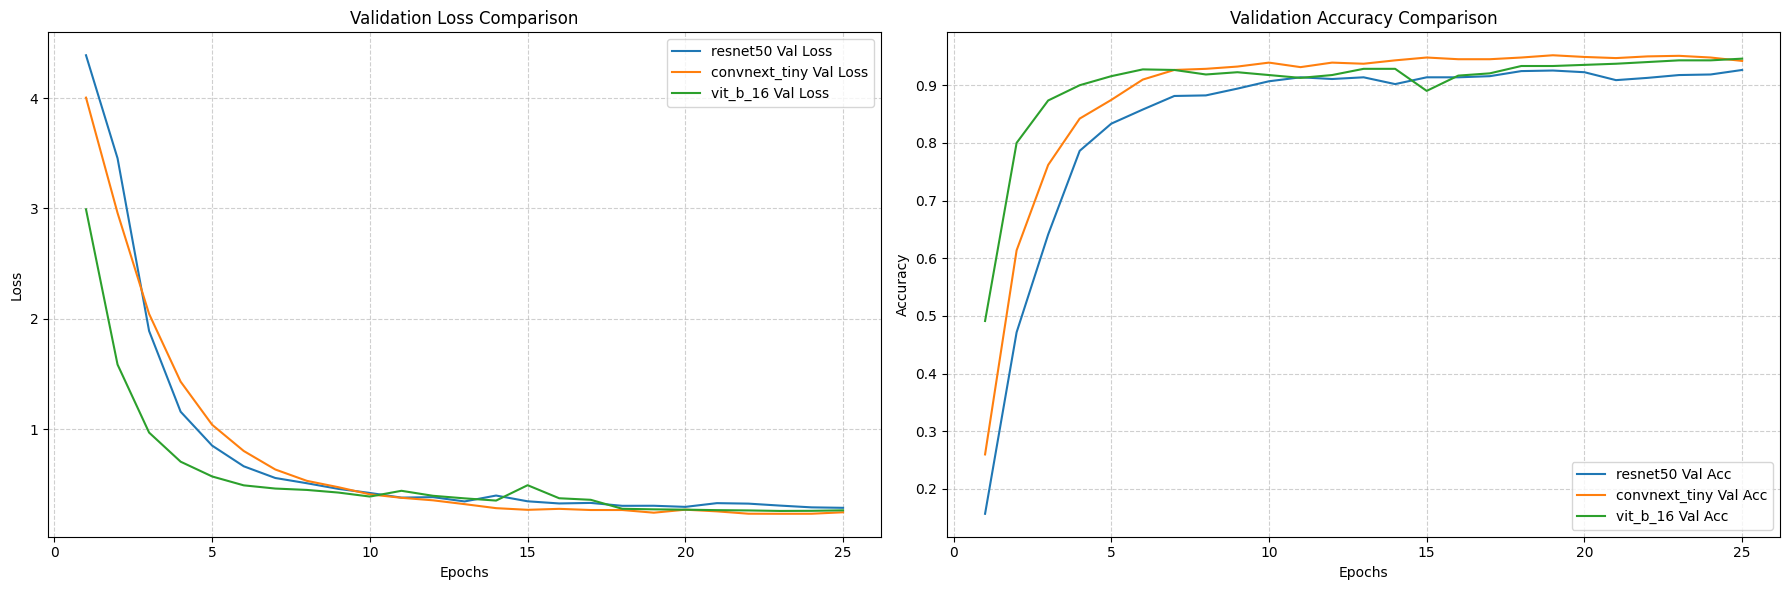

In [9]:
# Master dictionary to store results
all_results = {}

model_list = ["resnet50", "convnext_tiny", "vit_b_16"]

for m_name in model_list:
    print(f"\n--- Training {m_name} ---")

    # Initialize model, optimizer, etc. (using previous factory function)
    model = get_flower_model(model_name=m_name)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

    # Train
    trained_model, history = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        model_name=m_name, num_epochs=25
    )

    # Store history
    all_results[m_name] = history

# 3. Plot the comparison
plot_model_comparison(all_results)

Load the test dataset for model evaluation

In [10]:
# Use the same transforms as validation (no random cropping/flipping)
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the test split
test_dataset = datasets.Flowers102(root="data", split="test",
                                   download=True, transform=test_transforms)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of test samples: {len(test_dataset)}")

Number of test samples: 6149


To decide on which model that will be used for the next phase, the test dataset is evaluated. Here I only compare their accuracy for my final selection.

In [11]:
def evaluate_on_test_set(model, test_loader, device):

    model.eval()
    correct_1 = 0
    correct_5 = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Top-1 Accuracy
            _, pred = outputs.topk(1, 1, True, True)
            correct_1 += torch.eq(pred.view(-1), labels).sum().item()

            # Top-5 Accuracy
            _, pred5 = outputs.topk(5, 1, True, True)
            correct_5 += torch.eq(pred5, labels.view(-1, 1).expand_as(pred5)).sum().item()
            total += labels.size(0)

    top1_acc = 100 * correct_1 / total
    top5_acc = 100 * correct_5 / total

    print(f'Test Results:')
    print(f'Top-1 Accuracy: {top1_acc:.2f}%')
    print(f'Top-5 Accuracy: {top5_acc:.2f}%')
    return top1_acc, top5_acc

In [13]:

def evaluate_multiple_models(model_names, test_loader, device):
    all_test_results = {}

    for name in model_names:
        print(f"\n--- Evaluating {name} ---")

        # 1. Recreate the architecture using your factory function
        # Note: Set pretrained=False here because we are loading our OWN weights
        model = get_flower_model(model_name=name, pretrained=False)

        # 2. Load the specific saved weights for this model
        checkpoint_path = f"{name}_flowers.pt"
        try:
            model.load_state_dict(torch.load(checkpoint_path, map_location=device))
            model.to(device)

            # 3. Use your evaluation function
            top1, top5 = evaluate_on_test_set(model, test_loader, device)

            # 4. Store results
            all_test_results[name] = {"Top-1": top1, "Top-5": top5}

        except FileNotFoundError:
            print(f"Warning: Checkpoint {checkpoint_path} not found. Skipping...")

    return all_test_results

model_list = ["resnet50", "convnext_tiny", "vit_b_16"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_metrics = evaluate_multiple_models(model_list, test_loader, device)


--- Evaluating resnet50 ---
Test Results:
Top-1 Accuracy: 90.76%
Top-5 Accuracy: 97.80%

--- Evaluating convnext_tiny ---
Test Results:
Top-1 Accuracy: 93.76%
Top-5 Accuracy: 98.75%

--- Evaluating vit_b_16 ---
Test Results:
Top-1 Accuracy: 92.49%
Top-5 Accuracy: 97.92%


From the result on the test set above, it can be seen that the ConvNext model has the perfomance based on accuracy. However, I would suspect that if all 3 models are train longer, then I believe the result would favor the ViT model. For this assessment, all 3 models are trained for 25 epochs.


Final Model Comparison on Test Set:
                   Top-1      Top-5
convnext_tiny  93.755082  98.747764
vit_b_16       92.486583  97.918361
resnet50       90.762726  97.804521


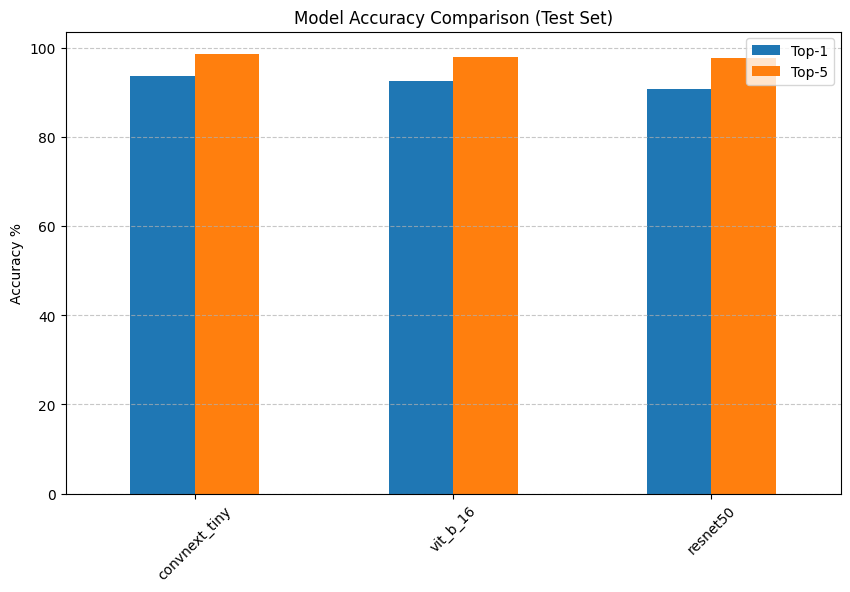

In [14]:
import pandas as pd

# Convert dictionary to DataFrame for a clean summary
results_df = pd.DataFrame(final_metrics).T
results_df = results_df.sort_values(by="Top-1", ascending=False)

print("\nFinal Model Comparison on Test Set:")
print(results_df)

# Optional: Plotting the comparison
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Accuracy Comparison (Test Set)")
plt.ylabel("Accuracy %")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Conclusion
The direction for my data augmentation was based on the previous EDA. Based on the test result, the ConvNext shows the highest accuracy on full fine tuning which is expected as the between the 3 models, the ConvNext is the current SOTA.
<p> Due to time constraint, if I have more time, my fine tuning approach would be different. I would train the first 5 epochs with frozen backbone, then after that use a full fine tuning. <p>
I would also like to note that the ConvNext model was the tiny variant. Should I have more time, I would use the large variant with the same setup.

In [ ]:
from sklearn.metrics import classification_report

def detailed_classification_report(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Generating report
    report = classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(102)])
    print(report)

detailed_classification_report(model, test_loader, device)

              precision    recall  f1-score   support

     Class 0       0.83      1.00      0.91        20
     Class 1       0.97      0.93      0.95        40
     Class 2       0.52      0.70      0.60        20
     Class 3       0.79      0.42      0.55        36
     Class 4       0.98      0.96      0.97        45
     Class 5       1.00      1.00      1.00        25
     Class 6       0.95      1.00      0.98        20
     Class 7       1.00      1.00      1.00        65
     Class 8       0.69      0.96      0.81        26
     Class 9       1.00      1.00      1.00        25
    Class 10       0.90      0.90      0.90        67
    Class 11       0.90      0.97      0.94        67
    Class 12       0.94      1.00      0.97        29
    Class 13       0.90      0.96      0.93        28
    Class 14       0.85      1.00      0.92        29
    Class 15       0.74      0.95      0.83        21
    Class 16       1.00      0.97      0.98        65
    Class 17       0.77    

In [ ]:
# Sort by F1-score to see the 5 worst-performing classes
worst_classes = report_df.iloc[:-3, :].sort_values(by='f1-score').head(5)
print("--- 5 Worst Performing Classes ---")
print(worst_classes[['precision', 'recall', 'f1-score']])

# Sort by F1-score to see the 5 best-performing classes
best_classes = report_df.iloc[:-3, :].sort_values(by='f1-score', ascending=False).head(5)
print("\n--- 5 Best Performing Classes ---")
print(best_classes[['precision', 'recall', 'f1-score']])

--- 5 Worst Performing Classes ---
           precision    recall  f1-score
Class 3     0.789474  0.416667  0.545455
Class 2     0.518519  0.700000  0.595745
Class 89    0.725490  0.596774  0.654867
Class 100   0.552239  0.973684  0.704762
Class 38    0.666667  0.761905  0.711111

--- 5 Best Performing Classes ---
          precision  recall  f1-score
Class 5         1.0     1.0       1.0
Class 7         1.0     1.0       1.0
Class 9         1.0     1.0       1.0
Class 26        1.0     1.0       1.0
Class 58        1.0     1.0       1.0


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# This is useful if you want to see the trade-off for a specific difficult class
def plot_precision_recall(all_labels, all_probs, class_id):
    precision, recall, _ = precision_recall_curve(all_labels == class_id, all_probs[:, class_id])
    plt.plot(recall, precision, lw=2, label=f'Class {class_id}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Class {class_id}')
    plt.legend()
    plt.show()

In [ ]:
import torch.nn.functional as F

def get_probs_and_labels(model, test_loader, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # Convert logits to probabilities using Softmax
            probs = F.softmax(outputs, dim=1)

            all_probs.append(probs.cpu())
            all_labels.append(labels)

    return torch.cat(all_labels).numpy(), torch.cat(all_probs).numpy()

# Execute collection
labels_np, probs_np = get_probs_and_labels(model, test_loader, device)

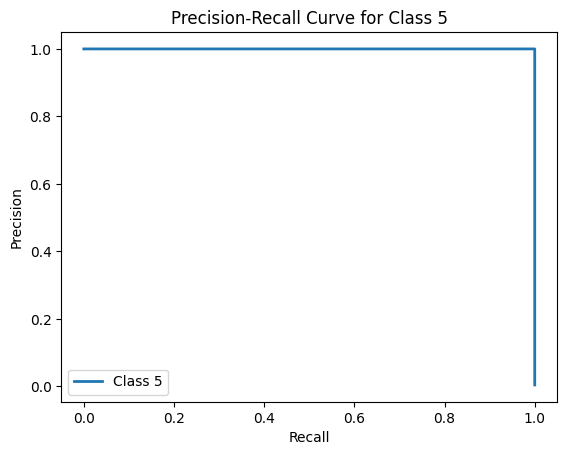

In [ ]:
# Choose a class ID you want to investigate (e.g., Class 1)
target_flower_id = 5

# Call the plotting function
plot_precision_recall(labels_np, probs_np, class_id=target_flower_id)

In [ ]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_tensor, class_idx):
        self.model.eval()
        output = self.model(input_tensor)

        # Backward pass for the specific class
        self.model.zero_grad()
        loss = output[0, class_idx]
        loss.backward()

        # Weight the channels by the corresponding gradients
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        heatmap = torch.sum(weights * self.activations, dim=1).squeeze()

        # ReLU on the heatmap and normalize
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        return heatmap.detach().cpu().numpy()

In [ ]:
import cv2

def display_gradcam(img_tensor, heatmap):
    # Convert tensor to image
    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

    # Resize heatmap to match image size and colorize
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the image
    overlay = heatmap.astype(np.float32) / 255 * 0.4 + img
    overlay = np.clip(overlay, 0, 1)

    plt.imshow(overlay)
    plt.axis('off')
    plt.show()



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


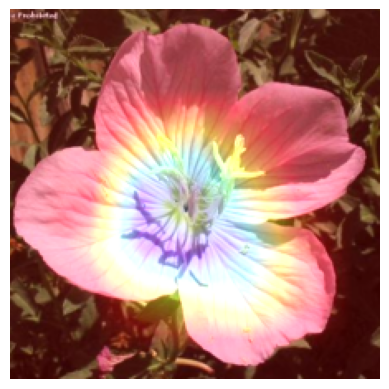

In [ ]:
# Usage:

# Get a single image and its true label from the validation loader
# Ensure it's on the correct device for the model
input_tensor, true_label = next(iter(val_loader))
input_tensor = input_tensor[0:1].to(device) # Take first image in batch and add batch dim
target_class = true_label[0].item() # Get the true class label for Grad-CAM

target_layer = model.layer4[-1] # Final conv layer of ResNet50
cam = GradCAM(model, target_layer)
mask = cam.generate_heatmap(input_tensor, class_idx=target_class)
display_gradcam(input_tensor, mask)

In [ ]:
def analyze_errors_with_gradcam(model, test_loader, cam_extractor, num_errors=5):
    model.eval()
    error_count = 0

    plt.figure(figsize=(20, 10))

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        for i in range(inputs.size(0)):
            if preds[i] != labels[i] and error_count < num_errors:
                # Generate heatmap for the WRONG prediction to see why it was chosen
                input_tensor = inputs[i].unsqueeze(0)
                heatmap = cam_extractor.generate_heatmap(input_tensor, class_idx=preds[i].item())

                # Plotting
                plt.subplot(2, num_errors, error_count + 1)

                # Show Original
                img = inputs[i].permute(1, 2, 0).cpu().numpy()
                img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
                plt.imshow(img)
                plt.title(f"Actual: {labels[i].item()}")
                plt.axis('off')

                # Show Grad-CAM Overlay
                plt.subplot(2, num_errors, error_count + num_errors + 1)
                display_gradcam_inline(inputs[i], heatmap)
                plt.title(f"Predicted: {preds[i].item()}")

                error_count += 1

        if error_count >= num_errors:
            break
    plt.tight_layout()
    plt.show()

# Helper for inline plotting
def display_gradcam_inline(img_tensor, heatmap):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = (heatmap.astype(np.float32) / 255 * 0.4) + img
    plt.imshow(np.clip(overlay, 0, 1))
    plt.axis('off')